# Tutorial 5: Vibration-based condition monitoring of rolling element bearings
## Imports and constants

In [75]:
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import hilbert

freq_e = 20480 # Hz, fréquence d'échantillonage
T_e = 488.28e-3 # s, période d'échantillonage

D = 2.815 # in, Diamètre du roulement 
d = 0.331 # in, Diamètre de l'élément roulant 
Nb = 16 # Nombre d'éléments roulants
beta = 0 # Angle de contact, inconnu donc supposé nul
freq_rot = 33.33 # Hz, fréquence de rotation

## Data load

In [8]:
datasets = []
for filename in os.listdir("./2nd_test"):
    dataset=pd.read_csv(os.path.join("./2nd_test", filename), sep='\t', names=['Bearing 1','Bearing 2','Bearing 3','Bearing 4'])
    dataset.index = [filename + "." + str(int(488.28*i)).zfill(7) for i in range(20480)]
    dataset.index = pd.to_datetime(dataset.index, format='%Y.%m.%d.%H.%M.%S.%f')
    datasets.append(dataset)

datasets = sorted(datasets, key = lambda dataset : dataset.index[0])
num_records = (100, 600, 850)
records = [datasets[i-1] for i in num_records]
print(datasets[0].head())

                               Bearing 1  Bearing 2  Bearing 3  Bearing 4
2004-02-12 10:32:39.000000000     -0.049     -0.071     -0.132     -0.010
2004-02-12 10:32:39.000048800     -0.042     -0.073     -0.007     -0.105
2004-02-12 10:32:39.000097600      0.015      0.000      0.007      0.000
2004-02-12 10:32:39.000146400     -0.051      0.020     -0.002      0.100
2004-02-12 10:32:39.000195300     -0.107      0.010      0.127      0.054


## Therorical failure frequencies of the bearing
### Formules
* BPFO = Nb/2 * (1 - d/D * cos(beta)) * F<sub>rot</sub>
* BSF<sup>the</sup> = D/d * (1 - (d/D * cos(beta))<sup>2</sup>) * F<sub>rot</sub> 
* BPFI = Nb/2 * (1 + d/D * cos(beta)) * F<sub>rot</sub>
* FTF = 1/2 * (1 - d/D * cos(beta)) * F<sub>rot</sub>

Avec les variables définie plus haut.

### Applications numériques

In [3]:
BPFO = Nb/2 * (1 - d/D * np.cos(beta)) * freq_rot
BSFthe = D/d * (1 - (d/D * np.cos(beta))**2) * freq_rot
BPFI = Nb/2 * (1 + d/D * np.cos(beta)) * freq_rot
FTF = 1/2 * (1 - d/D * np.cos(beta)) * freq_rot

print("BPFO =", BPFO, "Hz")
print("BSFthe =", BSFthe, "Hz")
print("BPFI =", BPFI, "Hz")
print("FTF =", FTF, "Hz")

BPFO = 235.28730373001775 Hz
BSFthe = 279.53695526232474 Hz
BPFI = 297.9926962699822 Hz
FTF = 14.70545648312611 Hz


## Time-domain analysis

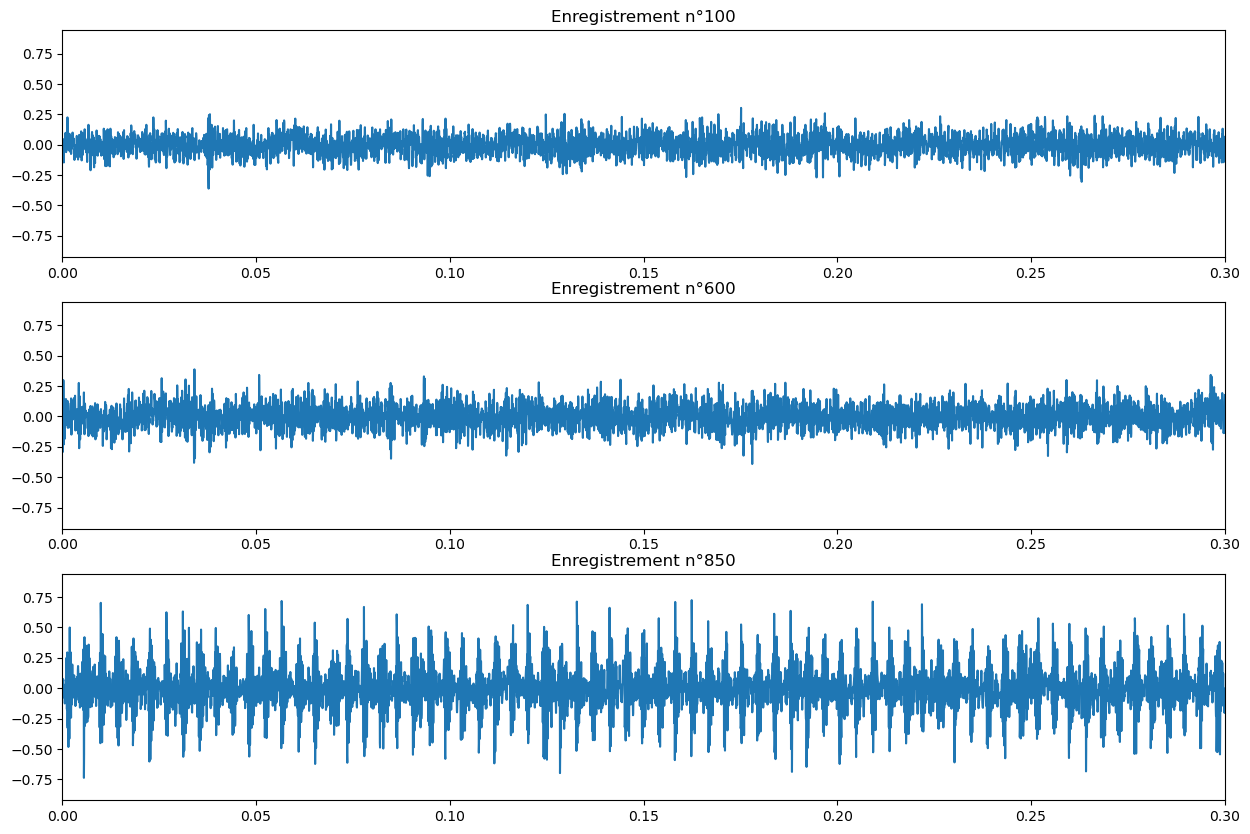

In [79]:
x = np.linspace(0, 1, len(records[0]["Bearing 1"]))

fig, axs = plt.subplots(3, sharey=True, figsize=(15, 10))
for i,record in zip(range(3),records):
    axs[i].plot(x, record["Bearing 1"])
    axs[i].set_title("Enregistrement n°" + str(num_records[i]))
    begin, end = 0, 0.30
    axs[i].set_xlim(begin, end)

On remarque que la fréquence des pics du défaut est de 71/0.3 = 236.67 Hz (71 pics relevés entre 0 et 0.3s sur l'enregistrement n°850 ci-dessus).

La fréquence de défaut la plus proche est la BPFO, indiquant un défaut de la bague externe (outer race fault).
Cette suposition est renforcée par la présence d'une unique ondulation transitoire à chaque perturbation.

## Frequency domain analysis on the spectrum

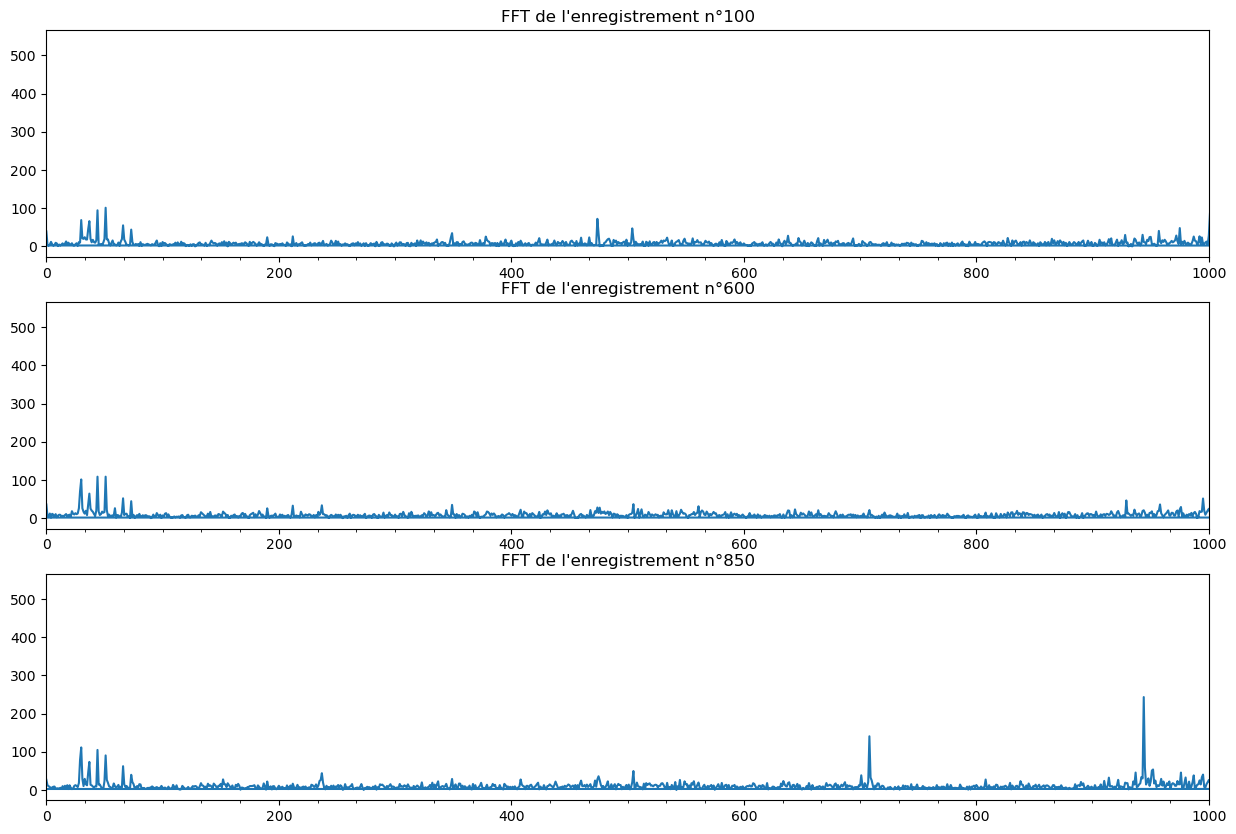

In [77]:
xf = fftfreq(len(records[0]["Bearing 1"]), 1/freq_e)

fig, axs = plt.subplots(3, sharey=True, figsize=(15, 10))
for i,record in zip(range(3),records):
    axs[i].plot(xf, np.abs(fft(record["Bearing 1"])))
    axs[i].set_title("FFT de l'enregistrement n°" + str(num_records[i]))
    begin, end = 0, 1000
    axs[i].set_xlim(begin, end)
    axs[i].set_xticks(np.arange(begin, end, 33.33), minor=True)

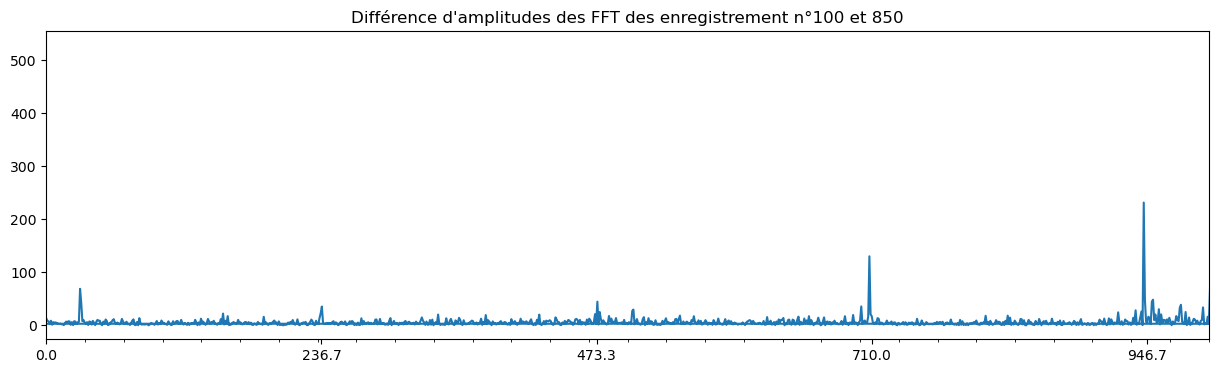

In [66]:
fig, ax = plt.subplots(1, figsize=(15, 4))
ax.plot(xf, np.abs(np.abs(fft(records[2]["Bearing 1"]))-np.abs(fft(records[0]["Bearing 1"]))))
begin, end = 0, 1000
ax.set_xlim(begin, end)
ax.set_title("Différence d'amplitudes des FFT des enregistrement n°100 et 850")
ax.set_xticks(np.arange(begin, end, 236.67))
ax.set_xticks(np.arange(begin, end, 33.33), minor=True)

On remarque sur le spectre de l'enregistrement n°850 des pics d'amplitudes aux fréquences harmoniques d'une fondamentale trouvée à la fréquence 236.67 Hz (mises en évidence ci-dessus), amenant à la même conclusion que précédemment : la fréquence de défaut la plus proche est la BPFO, indiquant un défaut de la bague externe.

## Calculation of the envelope and envelope spectrum

In [96]:
envelops = [np.square(np.abs(hilbert(record["Bearing 1"]))) for record in records]
spectrums = [np.abs(fft(envelop)) for envelop in envelops]

## Frequency domain analysis on the envelope spectrum

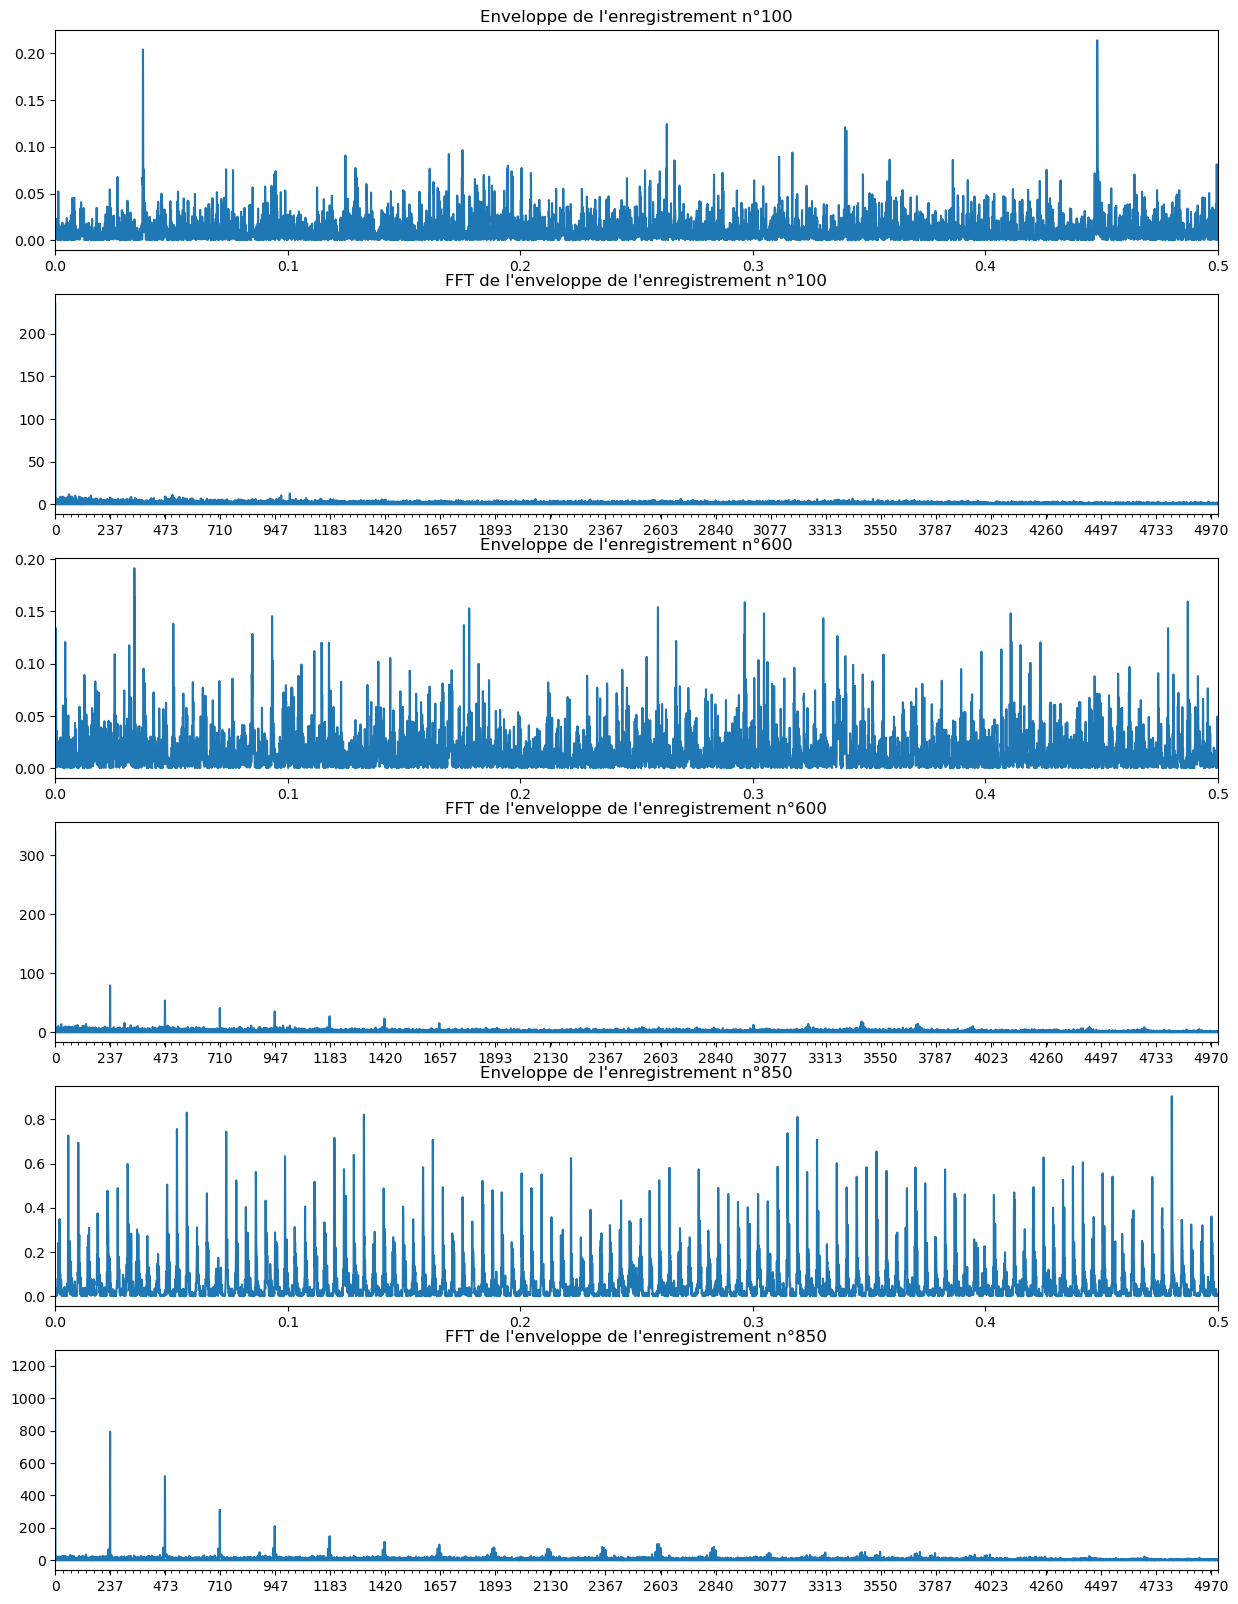

In [97]:
fig, axs = plt.subplots(6, figsize=(15, 20))
for i, envelop, spectrum in zip(range(3), envelops, spectrums):
    axs[2*i].plot(x, envelop)
    axs[2*i].set_title("Enveloppe de l'enregistrement n°" + str(num_records[i]))
    begin, end = 0, 0.5
    axs[2*i].set_xlim(begin, end)
    axs[2*i+1].plot(xf, spectrum)
    axs[2*i+1].set_title("FFT de l'enveloppe de l'enregistrement n°" + str(num_records[i]))
    begin, end = 0, 5000
    axs[2*i+1].set_xlim(begin, end)
    axs[2*i+1].set_xticks(np.arange(begin, end, 236.67))
    axs[2*i+1].set_xticks(np.arange(begin, end, 33.33), minor=True)

De la même manière que les analyses sur les domaines temporel et fréquentiel des signaux d'origine, on remarque, bien que plus aisément, sur l'enveloppe de l'enregistrement n°850 des pics à une fréquence de 118/0.5 = 236 Hz.

De même, on note des fréquences harmoniques d'une fondamentale trouvée à la fréquence 236 Hz sur le spectre de l'enveloppe des enregistrements n°600 et 850, cette fois bien plus identifiables.

Cela nous amène encore une fois à la même conclusion : la fréquence de défaut la plus proche est la BPFO, indiquant un défaut de la bague externe.